# Run ephys element workflow

This notebook walks you through the steps to run the ephys workflow.  
The workflow requires neuropixels meta file and kilosort output data. To configure the paths properly, refer to [00-Set_up_the_configuration_file](./00-Set_up_the_configuration_file.ipynb)

To load the local configuration, we will change the directory to the package root.

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)



Let's start by importing the relevant modules.

In [2]:
import datajoint as dj
from bl_pipeline import lab, subject, acquisition
from bl_pipeline.ephys_element import ephys_element, probe_element, get_session_cluster_rel_directory

Connecting alvaros@datajoint01.pni.princeton.edu:3306


# Pipeline structure

### + dj.Diagram is a useful command to visualize the workflow structure and table dependencies.
### + Two element modules have been installed into `bl_pipeline`: `probe_element` and `ephys_element`

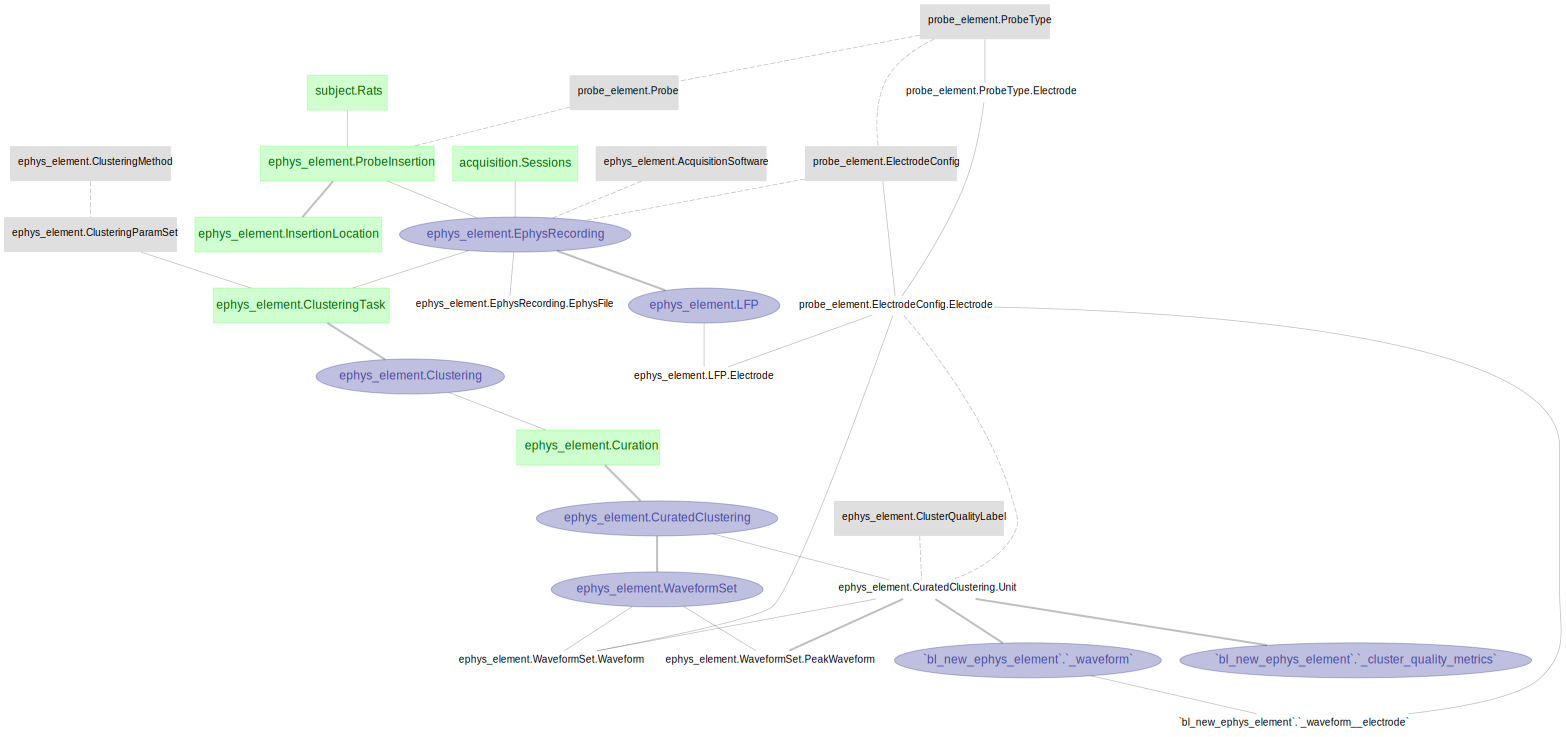

In [3]:
dj.Diagram(subject.Rats) + dj.Diagram(acquisition.Sessions) + dj.Diagram(probe_element) + dj.Diagram(ephys_element)

## Ephys element starts with table `ProbeInsertion`, as a child table of `subject.Rats`

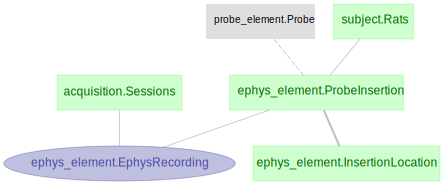

In [4]:
dj.Diagram(subject.Rats) + dj.Diagram(acquisition.Sessions) + dj.Diagram(probe_element.Probe) + \
(dj.Diagram(ephys_element.ProbeInsertion) + 1)

In [5]:

# As an example, we will work on the following session throughout the notebook:

In [6]:
session_key = (acquisition.Sessions & 'session_rat="A230"' & 'session_date="2019-08-26"').fetch1('KEY')
session_info  = (acquisition.Sessions & 'session_rat="A230"' & 'session_date="2019-08-26"').fetch1()
session_key

{'sessid': 725723}

## Ingest Probe and ProbeInsertion by ephys_element_ingest

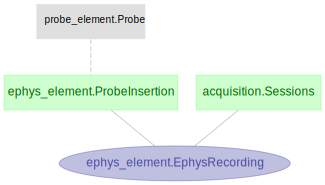

In [7]:
dj.Diagram(probe_element.Probe) + acquisition.Sessions + ephys_element.EphysRecording

A module `ephys_element_ingest` was provided to process a ephys session based on the neuropixel meta file: ingest entries into tables `Probe` and `ProbeInsertion`

In [8]:
from bl_pipeline.ingest import ephys_element_ingest
ephys_element_ingest.process_session(session_key)

As a result, there will contents in the following tables:

In [9]:
probe_element.Probe() & session_key

probe unique identifier for this model of probe (e.g. part number),probe_type e.g. neuropixels_1.0,probe_comment
18005106831,neuropixels 1.0 - 3B,
18194819132,neuropixels 1.0 - 3B,
18194819321,neuropixels 1.0 - 3B,


In [10]:
ephys_element.ProbeInsertion()

"ratname Unique rat name, 1 letter 3 numbers",insertion_number,probe unique identifier for this model of probe (e.g. part number),insertion_datetime
A230,0,18005106831,None
A249,0,18194819132,None
A256,0,18194819321,None


In [11]:
ephys_element.EphysRecording() & session_key

sessid Unique number assigned to each training session,"ratname Unique rat name, 1 letter 3 numbers",insertion_number,electrode_config_hash,acq_software,sampling_rate (Hz)
725723,A230,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,SpikeGLX,30000.5


## Populate EphysRecording

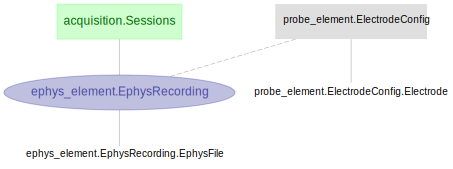

In [12]:
dj.Diagram(acquisition.Sessions) + (dj.Diagram(probe_element.ElectrodeConfig) + 1) + \
ephys_element.EphysRecording + ephys_element.EphysRecording.EphysFile

In [13]:
# first argument restricts the populate to a particular subset.
print(session_key)
ephys_element.EphysRecording.populate(session_key, display_progress=True)

{'sessid': 725723}


EphysRecording:   0%|          | 0/2 [00:00<?, ?it/s]


FileNotFoundError: No SpikeGLX data found for probe insertion: {'sessid': 725723, 'ratname': 'A249', 'insertion_number': 0}

Populate EphysRecording extracts the following information from .ap.meta file from SpikeGLX:

1. **probe_element.EelectrodeConfig**: this procedure detects new ElectrodeConfig, i.e. which 384 electrodes out of the total 960 on the probe were used in this ephys session, and save the results into the table `probe_element.EelectrodeConfig`. Each entry in table `ephys_element.EphysRecording` specifies which ElectrodeConfig is used in a particular ephys session. 

For this ephys session we just populated, Electrodes 0-383 was used.

In [14]:
probe_element.ElectrodeConfig()

electrode_config_hash,probe_type e.g. neuropixels_1.0,electrode_config_name user friendly name
6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,0-383


In [15]:
probe_element.ElectrodeConfig.Electrode()

electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0"
6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,0
6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,1
6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,2
6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,3
6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,4
6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,5
6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,6
6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,7
6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,8
6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,9


2. **ephys_element.EphysRecording**: note here that it refers to a particular electrode_config identified with a hash.

In [16]:
ephys_element.EphysRecording()

sessid Unique number assigned to each training session,"ratname Unique rat name, 1 letter 3 numbers",insertion_number,electrode_config_hash,acq_software,sampling_rate (Hz)
724159,A230,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,SpikeGLX,30000.5
725723,A230,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,SpikeGLX,30000.5
787269,A249,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,SpikeGLX,30000.2
787674,A256,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,SpikeGLX,30000.2


3. **ephys_element.EphysRecording.EphysFile**

In [17]:
ephys_element.EphysRecording.EphysFile() & session_key

sessid Unique number assigned to each training session,"ratname Unique rat name, 1 letter 3 numbers",insertion_number,file_path filepath relative to root data directory
725723,A230,0,Adrian/A230/A230_2019-08-26_g0/A230_2019-08-26_g0_imec0/A230_2019-08-26_g0_t0.imec0.ap.meta


## Create ClusteringTask and run/validate Clustering

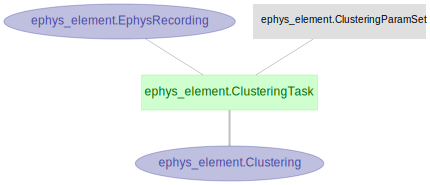

In [18]:
dj.Diagram(ephys_element.EphysRecording) + ephys_element.ClusteringParamSet + ephys_element.ClusteringTask + \
ephys_element.Clustering

The next major table in the ephys pipeline is the `ClusteringTask`.

+ In the future release of ephys elements, we will aim to trigger Clustering within the workflow, and register an entry in `ClusteringTask` is a manual step to let the pipeline know that there is a Clustering Task to be processed.

+ Currently, we have not supported the processing of Kilosort2 within the workflow. `ClusteringTask` is a place holder
indicating a Kilosort2 clustering task is finished and the clustering results are ready for processing. 

+ The `ClusteringTask` table depends on the table `ClusteringParamSet`, which are the parameters of the clustering task and needed to be inserted first. 

A method of the class `ClusteringParamSet` called `insert_new_params` helps on the insertion of params_set

In [19]:
# insert clustering task manually
params_ks = {
    "fs": 30000,
    "fshigh": 150,
    "minfr_goodchannels": 0.1,
    "Th": [10, 4],
    "lam": 10,
    "AUCsplit": 0.9,
    "minFR": 0.02,
    "momentum": [20, 400],
    "sigmaMask": 30,
    "ThPr": 8,
    "spkTh": -6,
    "reorder": 1,
    "nskip": 25,
    "GPU": 1,
    "Nfilt": 1024,
    "nfilt_factor": 4,
    "ntbuff": 64,
    "whiteningRange": 32,
    "nSkipCov": 25,
    "scaleproc": 200,
    "nPCs": 3,
    "useRAM": 0
}
ephys_element.ClusteringParamSet.insert_new_params(
    'kilosort2', 0, 'Spike sorting using Kilosort2', params_ks)
ephys_element.ClusteringParamSet()

paramset_idx,clustering_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,kilosort2,Spike sorting using Kilosort2,83f93e90-d8e0-1dca-5b2c-f65e2b0b3c61,=BLOB=


In [20]:
ephys_element.ClusteringTask()

sessid Unique number assigned to each training session,"ratname Unique rat name, 1 letter 3 numbers",insertion_number,paramset_idx,clustering_output_dir clustering output directory relative to root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation"
725723,A230,0,0,Adrian/A230/2019-08-26,load
787269,A249,0,0,NP_sorted/Adrian/A249/A249_2020_09_25/A249_2020_09_25_g0/spikesort_2020_11_18_09_57_50_ks2jrc,load
787674,A256,0,0,NP_sorted/Adrian/A256/A256_2020_09_28/A256_2020_09_28_g0/spikesort_2020_11_23_09_09_42_ks2jrc,load


We are then able to insert an entry into the `ClusteringTask` table. One important field of the table is `clustering_output_dir`, which specifies the Kilosort2 output directory for the later processing.  
**Note**: this output dir is a relative path to be combined with `clustering_root_directory` in the config file.

In [21]:
clust_dir = get_session_cluster_rel_directory(session_key)
ephys_element.ClusteringTask.insert1(
    dict(session_key, ratname=session_info['session_rat'], insertion_number=0, paramset_idx=0, clustering_output_dir=clust_dir), skip_duplicates=True)

In [22]:
ephys_element.ClusteringTask() & session_key

sessid Unique number assigned to each training session,"ratname Unique rat name, 1 letter 3 numbers",insertion_number,paramset_idx,clustering_output_dir clustering output directory relative to root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation"
725723,A230,0,0,Adrian/A230/2019-08-26,load


We are then able to populate the clustering results. The `Clustering` table now validates the Kilosort2 outcomes before ingesting the spike sorted results. In the future release of elements-ephys, this table will be used to trigger Kilosort2. A record in the `Clustering` indicates that Kilosort2 job is done successfully and the results are ready to be processed.

In [23]:
ephys_element.Clustering.populate(session_key, display_progress=True)

Clustering:   0%|          | 0/1 [00:00<?, ?it/s]


FileNotFoundError: No valid full-path found (from [WindowsPath('//apps02.pni.princeton.edu/archive-labdata/brody/RATTER/PhysData/Raw')]) for Adrian\A230\2019-08-26

In [14]:
ephys_element.Clustering() & session_key

sessid Unique number assigned to each training session,"ratname Unique rat name, 1 letter 3 numbers",insertion_number,paramset_idx,clustering_time time of generation of this set of clustering results


## Import clustering results and manually curated results

We are now ready to ingest the clustering results (spike times etc.) into the database. These clustering results are either directly from Kilosort2 or with manual curation. Both ways share the same format of files. In the element, there is a `Curation` table that saves this information.

In [ ]:
dj.Diagram(ephys_element.ClusteringTask) + ephys_element.Clustering + ephys_element.Curation + \
ephys_element.CuratedClustering + ephys_element.CuratedClustering.Unit

In [ ]:
#

In [ ]:

key = (ephys_element.ClusteringTask & session_key).fetch1('KEY')
ephys_element.Curation().create1_from_clustering_task(key)
ephys_element.Curation() & session_key

# Then we could populate table `CuratedClustering`, ingesting either the output of Kilosort2 or the curated results.

ephys_element.CuratedClustering.populate(session_key, display_progress=True)

# The part table `CuratedClustering.Unit` contains the spike sorted units

ephys_element.CuratedClustering.Unit()

# ## Populate LFP and spike waveform

# There are two additional tables in the ephys_element that is able to get automatically processed:

In [ ]:

dj.Diagram(ephys_element.EphysRecording) + ephys_element.LFP + ephys_element.LFP.Electrode

ephys_element.LFP.populate(session_key, display_progress=True)
ephys_element.LFP & session_key

ephys_element.LFP.Electrode & session_key

dj.Diagram(ephys_element.CuratedClustering.Unit) + ephys_element.Waveform

In [ ]:
ephys_element.Waveform.populate(session_key, display_progress=True)

In [ ]:
ephys_element.LFP.Electrode & session_key